## 0. Install TensorFlow 2.0

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

## 1. Load image data

In [2]:
import tensorflow_datasets as tfds

batch_size = 64

print(tfds.list_builders())
dataset = tfds.load('cifar10')
dataset = dataset['train']
dataset = dataset.batch(batch_size)

['abstract_reasoning', 'bair_robot_pushing_small', 'caltech101', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_corrupted', 'cnn_dailymail', 'coco2014', 'colorectal_histology', 'colorectal_histology_large', 'cycle_gan', 'diabetic_retinopathy_detection', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'fashion_mnist', 'flores', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imdb_reviews', 'iris', 'kmnist', 'lm1b', 'lsun', 'mnist', 'moving_mnist', 'multi_nli', 'nsynth', 'omniglot', 'open_images_v4', 'oxford_flowers102', 'oxford_iiit_pet', 'para_crawl', 'quickdraw_bitmap', 'rock_paper_scissors', 'shapes3d', 'smallnorb', 'squad', 'starcraft_video', 'sun397', 'svhn_cropped', 'ted_hrlr_translate', 'ted_multi_translate', 'tf_flowers', 'titanic', 'ucf101', 'voc2007', 'wikipedia', 'wmt14_translate', 'wmt15_translate', 'wmt16_translate', 'wmt17_translate', 'wmt18_t

## 2. Data Augmentation

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, cutout_mask_size = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cutout_mask_size = cutout_mask_size
    
    def cutout(self, x, y):
        return np.array(list(map(self._cutout, x))), y
    
    def _cutout(self, image_origin):
        # 最後に使うfill()は元の画像を書き換えるので、コピーしておく
        image = np.copy(image_origin)
        mask_value = image.mean()

        h, w, _ = image.shape
        # マスクをかける場所のtop, leftをランダムに決める
        # はみ出すことを許すので、0以上ではなく負の値もとる(最大mask_size // 2はみ出す)
        top = np.random.randint(0 - self.cutout_mask_size // 2, h - self.cutout_mask_size)
        left = np.random.randint(0 - self.cutout_mask_size // 2, w - self.cutout_mask_size)
        bottom = top + self.cutout_mask_size
        right = left + self.cutout_mask_size

        # はみ出した場合の処理
        if top < 0:
            top = 0
        if left < 0:
            left = 0

        # マスク部分の画素値を平均値で埋める
        image[top:bottom, left:right, :].fill(mask_value)
        return image
    
    def flow(self, *args, **kwargs):
        batches = super().flow(*args, **kwargs)
        
        # 拡張処理
        while True:
            batch_x, batch_y = next(batches)
            
            if self.cutout_mask_size > 0:
                result = self.cutout(batch_x, batch_y)
                batch_x, batch_y = result                        
                
            yield (batch_x, batch_y)     
    
datagen = CustomImageDataGenerator(rotation_range=10, horizontal_flip=True, zoom_range=0.1, cutout_mask_size=16)

## 3. Display the result

(64, 32, 32, 3)


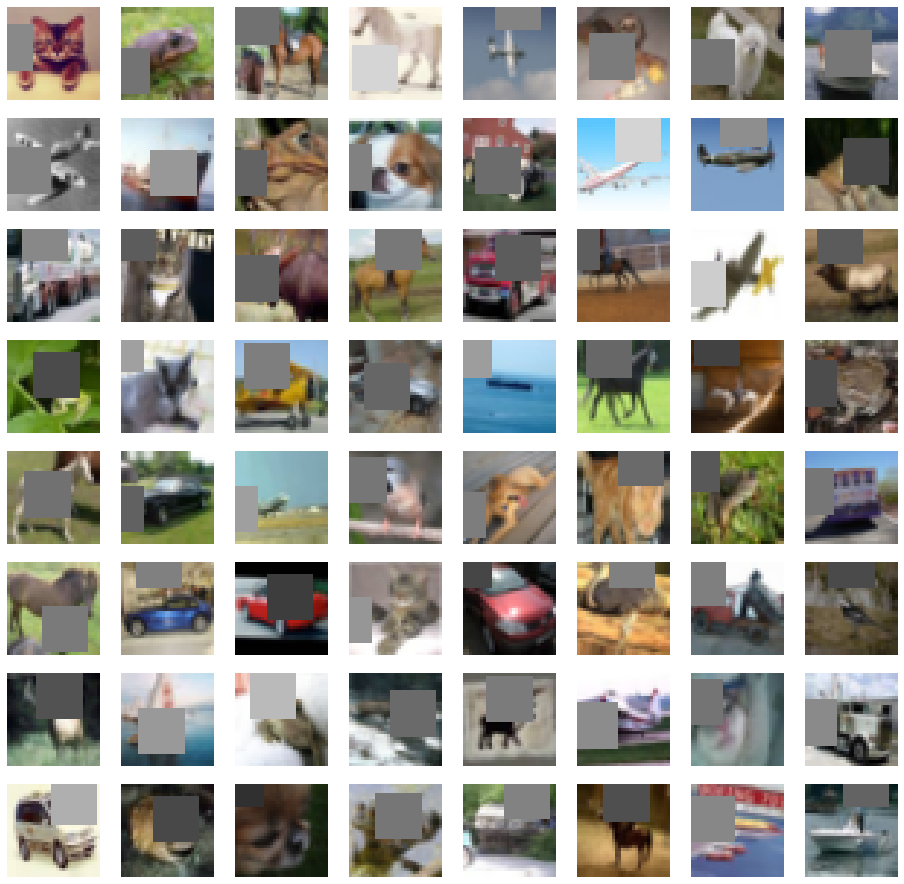

In [4]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf

column_size = math.floor(math.sqrt(batch_size))
row_size = math.ceil(batch_size / column_size)
fig, ax = plt.subplots(row_size, column_size, figsize = (row_size * 2, column_size * 2), subplot_kw = {'xticks': (), 'yticks': ()})

for axis in ax:
    for a in axis:
        a.set_axis_off()

for data_list in dataset:    
    image_list = data_list['image']
    label_list = data_list['label']

    row, column = 0, 0
    for x, y in datagen.flow(image_list, label_list, batch_size = batch_size):
        print(x.shape)
        for _x in x:
            _x = tf.cast(_x, tf.uint8)
            ax[row, column].imshow(_x)
            if column == column_size - 1:
                column = 0
                row += 1
            else:
                column += 1
        break
    break